In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
df = pd.read_csv('wholesale_customers_data.csv')
df.sample(n=8)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
55,1,3,5264,3683,5005,1057,2024,1130
28,2,3,4113,20484,25957,1158,8604,5206
19,1,3,7780,2495,9464,669,2518,501
234,1,1,15603,2703,3833,4260,325,2563
164,2,3,5224,7603,8584,2540,3674,238
48,2,3,11519,6152,10868,584,5121,1476
148,1,3,5924,584,542,4052,283,434
382,1,3,34454,7435,8469,2540,1711,2893


In [3]:
df.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [4]:
df.shape

(440, 8)

In [5]:
data = df.copy()

for cols in data.columns[2:]:
  Q1 = data[cols].quantile(0.25)
  Q3 = data[cols].quantile(0.75)
  iqr = Q3 - Q1

  low = Q1-1.5*iqr
  high = Q3+1.5*iqr
  data.loc[(data[cols] < low) | (data[cols] > high), cols] = data[cols].median()

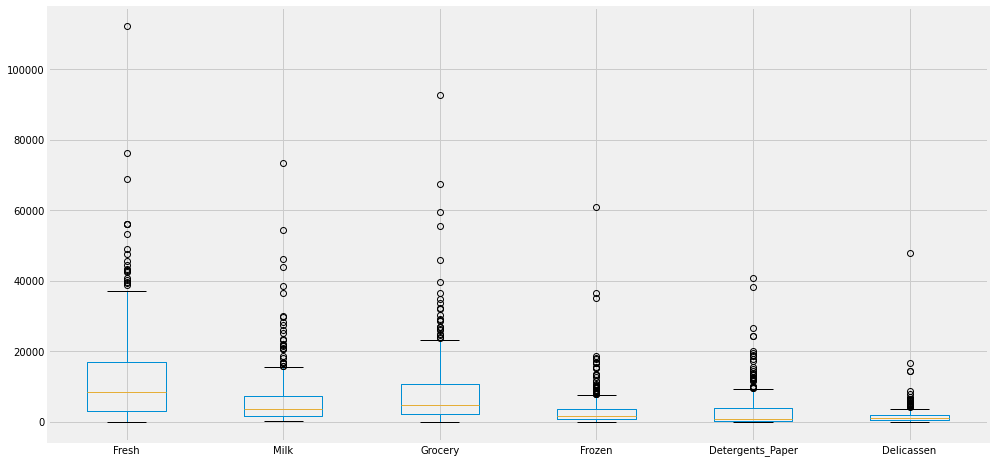

In [6]:
df.iloc[:, 2:].boxplot(figsize=(15,8))

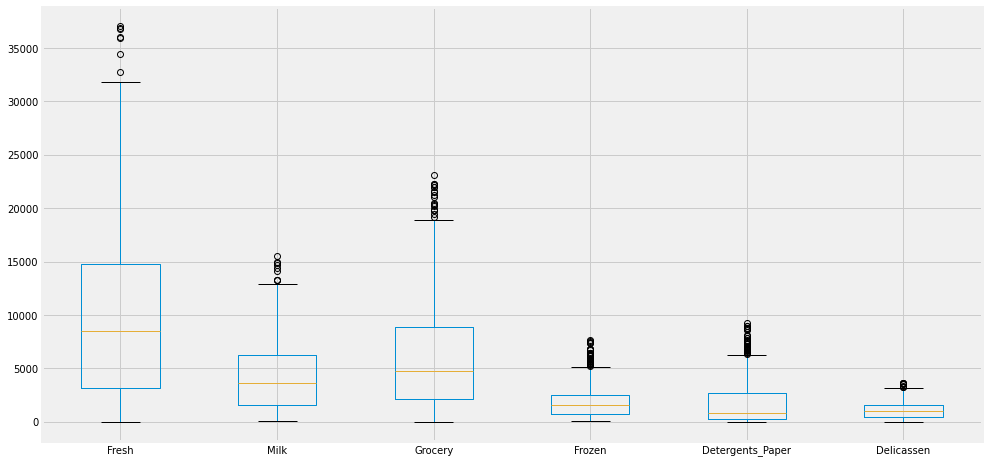

In [7]:
data.iloc[:, 2:].boxplot(figsize=(15,8))

In [8]:
from scipy.stats import zscore


data = data.apply(zscore)
data = pd.DataFrame(data, columns=df.columns)
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.312278,1.581331,0.251637,-1.005765,0.384841,0.302219
1,1.448652,0.590668,-0.352577,1.626645,0.627928,-0.080488,0.659291,0.823978
2,1.448652,0.590668,-0.435980,1.331810,0.274698,0.303849,0.758164,-0.141514
3,-0.690297,0.590668,0.382886,-0.907994,-0.374579,2.694150,-0.575956,0.838273
4,1.448652,0.590668,1.490583,0.331960,0.183578,1.206413,-0.012868,-0.141514


In [9]:
data.shape

(440, 8)

In [10]:
from sklearn.cluster import KMeans

best_k = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(data)
    best_k.append([k, kmeans.inertia_])

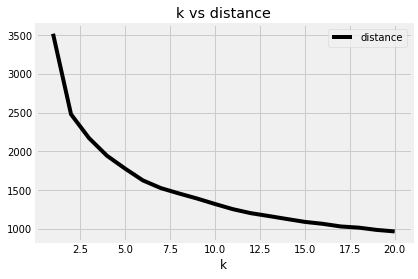

In [11]:
best_k = pd.DataFrame(best_k, columns=['k', 'distance'])

best_k.plot(
    x='k',
    y='distance',
    color='k',
    title='k vs distance',
)

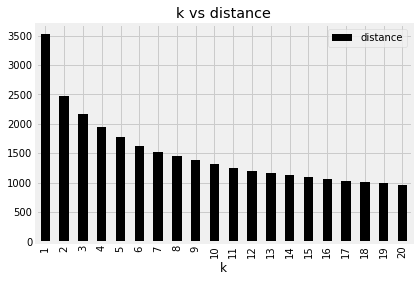

In [19]:
best_k.plot(
    kind='bar',
    x='k',
    y='distance',
    color='k',
    title='k vs distance',
)

In [12]:
kmeans = KMeans(n_clusters=6, random_state=7)
y_pred_kmeans = kmeans.fit_predict(data)

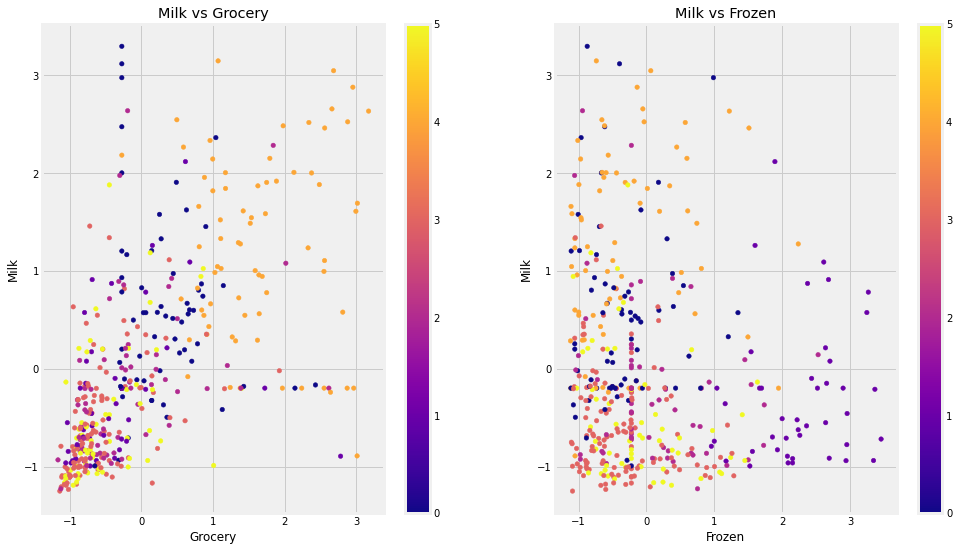

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 9))
data.plot(
    kind='scatter',
    title='Milk vs Grocery',
    x='Grocery',
    y='Milk',
    c=y_pred_kmeans,
    s=20,
    ax=axs[0],
    cmap='plasma',
)

data.plot(
    kind='scatter',
    title='Milk vs Frozen',
    x='Frozen',
    y='Milk',
    c=y_pred_kmeans,
    s=20,
    ax=axs[1],
    cmap='plasma',
)

In [14]:
from sklearn.cluster import MeanShift

# set bandwith to 0.4
meanshift = MeanShift(bandwidth=.4)
y_pred_shift = meanshift.fit_predict(data)

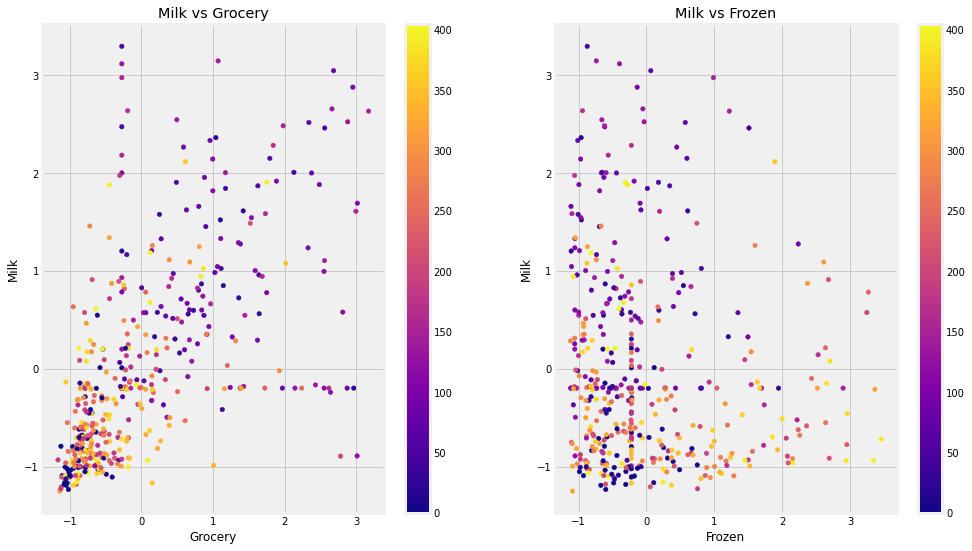

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 9))
data.plot(
    kind='scatter',
    title='Milk vs Grocery',
    x='Grocery',
    y='Milk',
    c=y_pred_shift,
    s=20,
    ax=axs[0],
    cmap='plasma',
)

data.plot(
    kind='scatter',
    title='Milk vs Frozen',
    x='Frozen',
    y='Milk',
    c=y_pred_shift,
    s=20,
    ax=axs[1],
    cmap='plasma',
)

In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1)
y_pred_dbscan = dbscan.fit_predict(data)

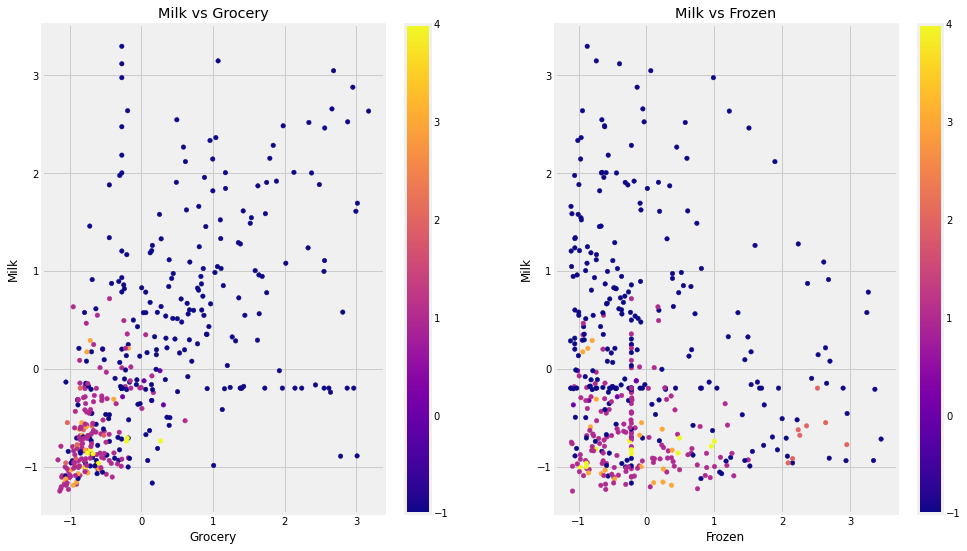

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 9))
data.plot(
    kind='scatter',
    title='Milk vs Grocery',
    x='Grocery',
    y='Milk',
    c=y_pred_dbscan,
    s=20,
    ax=axs[0],
    cmap='plasma',
)

data.plot(
    kind='scatter',
    title='Milk vs Frozen',
    x='Frozen',
    y='Milk',
    c=y_pred_dbscan,
    s=20,
    ax=axs[1],
    cmap='plasma',
)

In [18]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
)

kmeans_silhouette_score = silhouette_score(data, y_pred_kmeans, metric='euclidean')
meanshift_silhouette_score = silhouette_score(data, y_pred_shift, metric='euclidean')
dbscan_silhouette_score = silhouette_score(data, y_pred_dbscan, metric='euclidean')

kmeans_calinski_score = calinski_harabasz_score(data, y_pred_kmeans)
meanshift_calinski_score = calinski_harabasz_score(data, y_pred_shift)
dbscan_calinski_score = calinski_harabasz_score(data, y_pred_dbscan)


results = pd.DataFrame({
   'kmeans': [kmeans_silhouette_score, kmeans_calinski_score],
   'meanshift': [meanshift_silhouette_score, meanshift_calinski_score ],
   'dbscan': [dbscan_silhouette_score, dbscan_calinski_score],
   'score_type': ['silhouette', 'calinski_harabasz']
},

)

results = results.set_index(results['score_type'])
results

,kmeans,meanshift,dbscan,score_type
score_type,,,,
silhouette,0.214540,0.038184,-0.087208,silhouette
calinski_harabasz,101.115678,112.985329,26.091335,calinski_harabasz


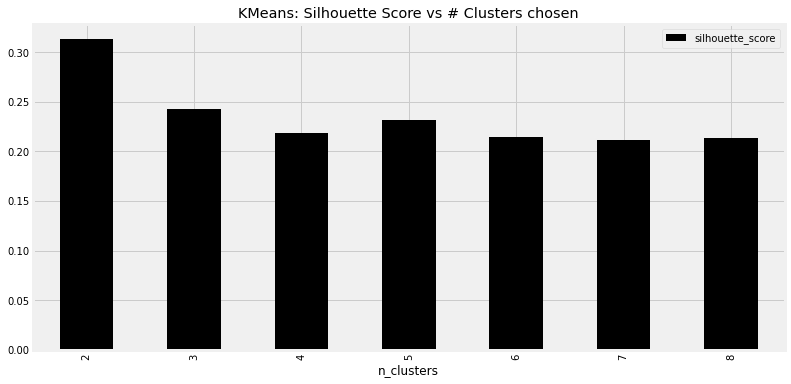

In [22]:
n_clusters_option = list(range(2, 9))
silhouette_scores = []

for i, n_clusters in enumerate(n_clusters_option):
  kmeans = KMeans(n_clusters=n_clusters, random_state=7)
  y_pred_kmeans = kmeans.fit_predict(data)
  silhouette_scores.append(silhouette_score(data, y_pred_kmeans))


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
pd.DataFrame(
    {
        'n_clusters': n_clusters_option,
        'silhouette_score': silhouette_scores,
     
    }
).set_index('n_clusters').plot(
    kind='bar',
    color='k',
    title='KMeans: Silhouette Score vs # Clusters chosen',
    ax=ax,
)

In [23]:
kmeans = KMeans(n_clusters=2, random_state=7)
y_pred_kmeans = kmeans.fit_predict(data)
kmeans_silhouette_score = silhouette_score(data, y_pred_kmeans, metric='euclidean')

kmeans_silhouette_score

0.3129631439593068